In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from statsmodels.graphics.gofplots import ProbPlot


## Helper functions!

In [2]:
# define function to compute test MSEs
def comp_mse(model, temp_data):
    predictions = model.predict(temp_data)
    mse_test = np.mean((temp_data['Withdraw']-predictions)**2)    
    return mse_test

## Read the data

In [3]:
# Read the data
data=pd.read_csv('ATM_sample.csv')
data.head()

# Define target variable
y = data['Withdraw']

# Define the input variables
X = data.drop(columns=['Withdraw'])

X.columns

Index(['Shops', 'ATMs', 'Downtown', 'Weekday', 'Center', 'High'], dtype='object')

## Alter the input columns (X) as you see fit

The following example adds combination variables split on downtown.

In [4]:
X_temp = X.drop(columns=['Downtown']).mul(X['Downtown'], axis=0).rename(columns={'Shops': "Shops_DT", 'ATMs': "ATMs_DT", 'Weekday': "Weekday__DT", 'Center': 'Center_DT', 'High': "High_DT"})  

X_temp['Downtown_NotWeekday_Center'] = X['Downtown'] * (1 - X['Weekday'] ) * X['Center']
X_temp["Shops_DWC"] = X_temp['Downtown_NotWeekday_Center'] * X['Shops'] 

X_new = pd.concat([X_temp,X], axis=1)
X_new.head()

,Shops_DT,ATMs_DT,Weekday__DT,Center_DT,High_DT,Downtown_NotWeekday_Center,Shops_DWC,Shops,ATMs,Downtown,Weekday,Center,High
0,1018,10,0,0,0,0,0,1018,10,1,0,0,0
1,974,10,1,0,0,0,0,974,10,1,1,0,0
2,0,0,0,0,0,0,0,96,2,0,0,0,1
3,958,9,1,0,1,0,0,958,9,1,1,0,1
4,0,0,0,0,0,0,0,103,4,0,1,0,1


## Pre Process the data ad Build the Model
 

In [5]:
# Preprocess the data 
X_train, X_test, y_train, y_test = train_test_split(
    X_new,              # Features
    y,                  # Target variable
    test_size=0.2,      # 20% for testing, 80% for training
    random_state=1      # Set for reproducibility
)

train = pd.concat([y_train,X_train], axis=1)
test = pd.concat([y_test,X_test], axis=1)
 

# Build and execute model
formula = "Withdraw ~ Shops_DT + Weekday__DT + Center_DT + Shops_DWC + Shops + ATMs + Downtown + Weekday + Center + High" 
model = ols(formula, data=train).fit()  
print(comp_mse(model, test))

0.2689971805072948


In [6]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.062e+06
Date:                Mon, 04 Nov 2024   Prob (F-statistic):               0.00
Time:                        10:52:07   Log-Likelihood:                -13504.
No. Observations:               17600   AIC:                         2.703e+04
Df Residuals:                   17589   BIC:                         2.712e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      18.8151      0.143    131.233      0.000      18.534      19.096
Shops_DT        0.0916      0.001     63.424      0.000       0.089       0.094
Weekday__DT     0.2245      0.019     11.644      0.000       0.187       0.262
Center_DT      -0.5775      0.030    -19.168      0.000      -0.637      -0.518
Shops_DWC       0.0200   3.42e-05    583.520      0.000       0.020       0.020
Shops           0.0185      0.001     12.969      0.000       0.016       0.021
ATMs           -1.0005      0.002   -455.001      0.000      -1.005      -0.996
Downtown      -47.8967      0.272   -175.809      0.000     -48.431     -47.363
Weekday        -2.2178      0.016   -140.071      0.000      -2.249      -2.187
Center          3.5912      0.024    150.664      0.000       3.545       3.638
High            1.0020      0.009    116.833      0.000       0.985       1.019
==============================================================================
Omnibus:                       64.483   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.312
Skew:                           0.113   Prob(JB):                     5.39e-16
Kurtosis:                       3.212   Cond. No.                     8.60e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.6e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [7]:
robust_model = model.get_robustcov_results(cov_type='HC0')
robust_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Withdraw   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.158e+06
Date:                Mon, 04 Nov 2024   Prob (F-statistic):               0.00
Time:                        10:52:07   Log-Likelihood:                -13504.
No. Observations:               17600   AIC:                         2.703e+04
Df Residuals:                   17589   BIC:                         2.712e+04
Df Model:                          10                                         
Covariance Type:                  HC0                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      18.8151      0.160    117.777      0.000      18.502      19.128
Shops_DT        0.0916      0.002     56.992      0.000       0.088       0.095
Weekday__DT     0.2245      0.022     10.433      0.000       0.182       0.267
Center_DT      -0.5775      0.045    -12.753      0.000      -0.666      -0.489
Shops_DWC       0.0200   3.04e-05    656.326      0.000       0.020       0.020
Shops           0.0185      0.002     11.617      0.000       0.015       0.022
ATMs           -1.0005      0.002   -475.401      0.000      -1.005      -0.996
Downtown      -47.8967      0.275   -173.933      0.000     -48.436     -47.357
Weekday        -2.2178      0.019   -118.054      0.000      -2.255      -2.181
Center          3.5912      0.042     85.344      0.000       3.509       3.674
High            1.0020      0.009    116.591      0.000       0.985       1.019
==============================================================================
Omnibus:                       64.483   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               70.312
Skew:                           0.113   Prob(JB):                     5.39e-16
Kurtosis:                       3.212   Cond. No.                     8.60e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 8.6e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
robust_model.formula

AttributeError: 'OLSResults' object has no attribute 'formula'

Doing some manual cross validation checking to assess if doing cross validation is necessary. From these, we can see that it is a pretty stable result, thus, I don't think it is necessary to perform cross validation on the model selection. 

I guess the shops x dt x c x w makes sense bc its the same as having dt x c x w but with more granularity to it. This model prioritises interpretability.

## Diagnostic Plots (Plotting the residuals)

In [8]:
# model values
model_fitted_y = model.fittedvalues

# model residuals
model_residuals = model.resid

# normalized residuals 
model_norm_residuals = model.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = model.get_influence().hat_matrix_diag

# cook's distance, from statsmodels internals
model_cooks = model.get_influence().cooks_distance[0]

Text(0, 0.5, 'Residuals')

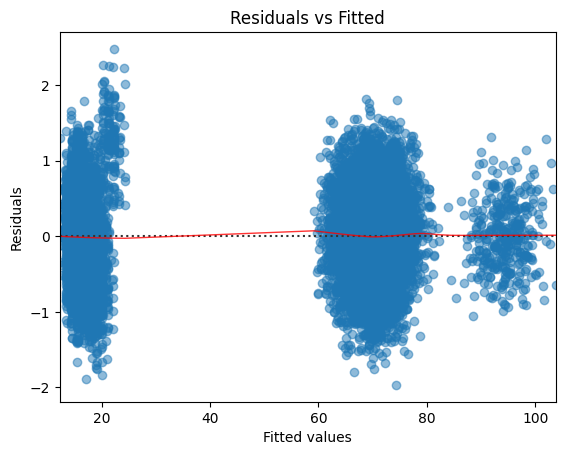

In [9]:
plot_lm = plt.figure()
plot_lm.axes[0] = sns.residplot(x=model_fitted_y, 
                               y='Withdraw',
                               data=train,
                               lowess=True,
                               scatter_kws={'alpha': 0.5},
                               line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm.axes[0].set_title('Residuals vs Fitted')
plot_lm.axes[0].set_xlabel('Fitted values')
plot_lm.axes[0].set_ylabel('Residuals') 

/Users/tom/virt_envs/econ3203_1/lib/python3.12/site-packages/statsmodels/graphics/gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


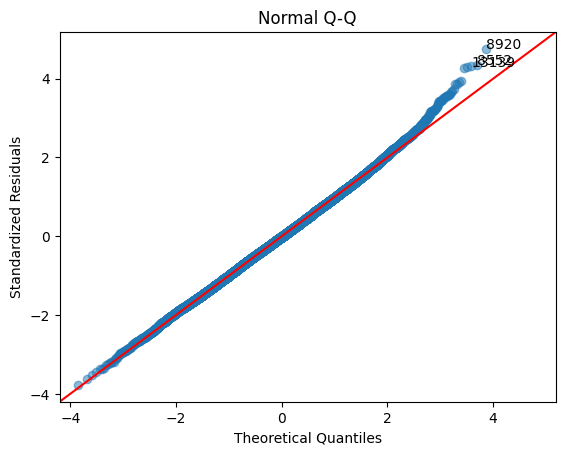

In [10]:
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');
# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:3]
for r, i in enumerate(abs_norm_resid_top_3):
    plot_lm_2.axes[0].annotate(i,
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]));